# Restricted Boltzmann Machine - MNIST

## Imports

In [2]:
import sys, datetime
import itertools as it
import scipy
import itertools
import tqdm
import os
import glob
import numba
from collections import Counter
from numba import njit, prange, vectorize
import ast



# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir SingleTrain
!mkdir TestTrain
!mkdir KFoldCV

mkdir: SingleTrain: File exists
mkdir: TestTrain: File exists
mkdir: KFoldCV: File exists


## Load data

In [3]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
print(X_original.shape)

(70000, 784)


## Parameters

In [4]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


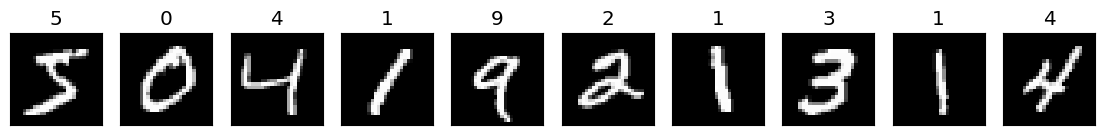

first 10 MNIST-3 data points


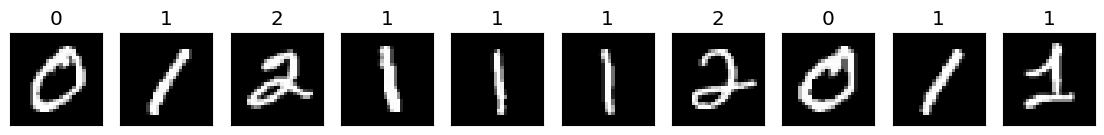

first 10 MNIST-3 data points, binarized


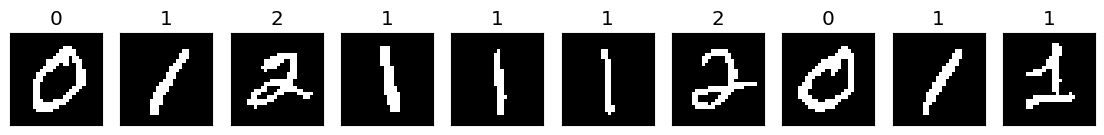

each of Nd=21770 data has D=784 bits


In [5]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')



## Plotting data stats

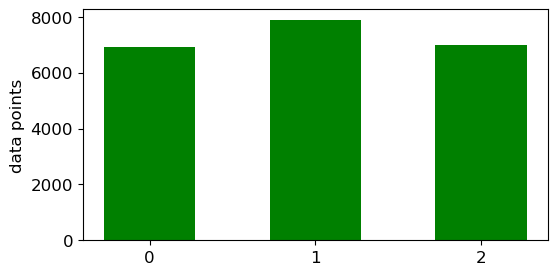

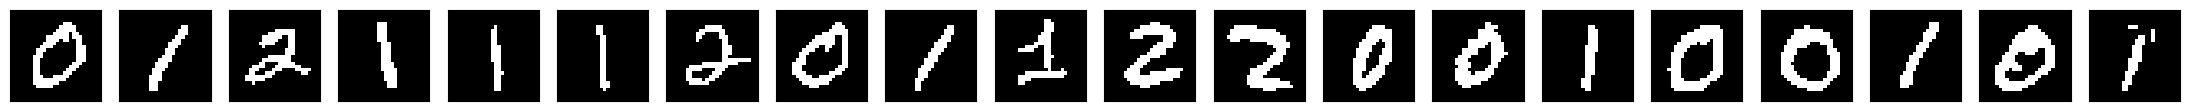

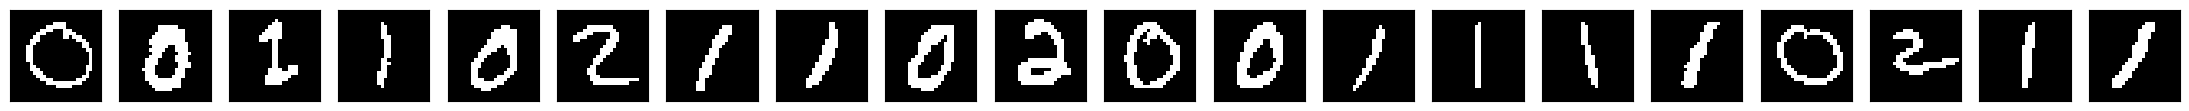

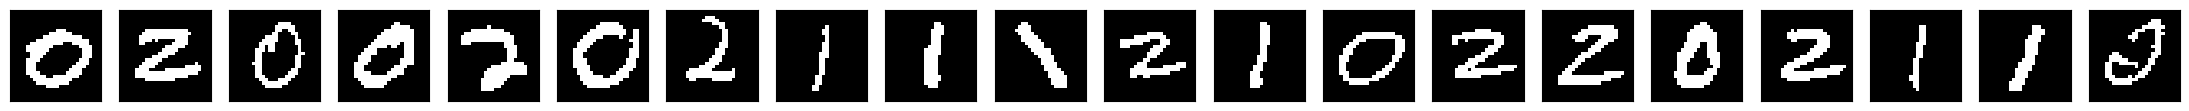

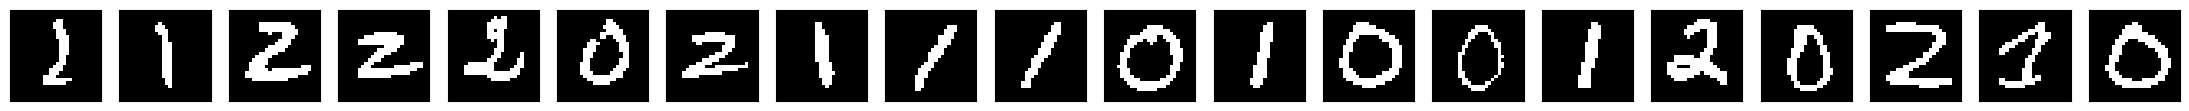

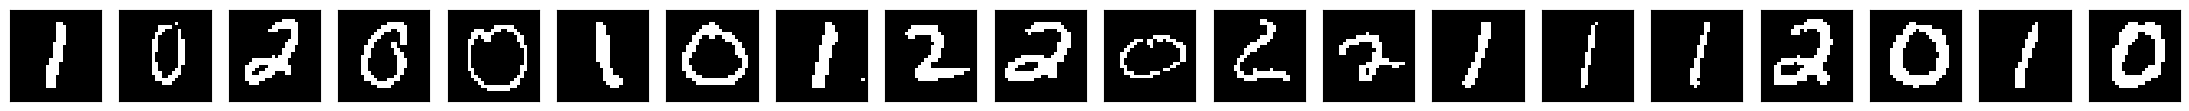

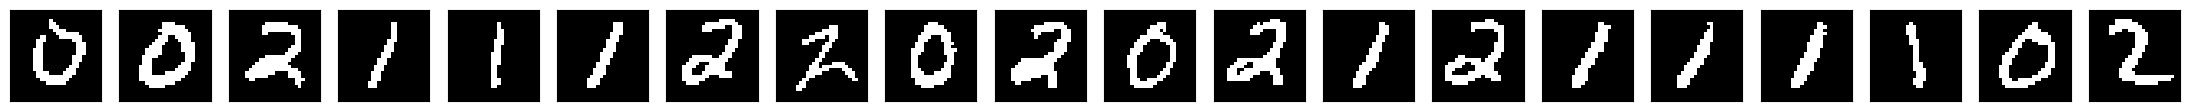

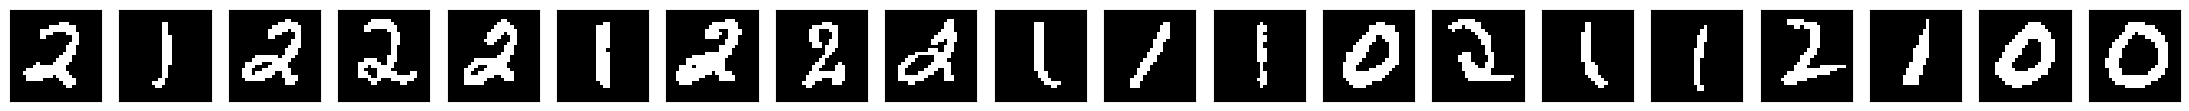

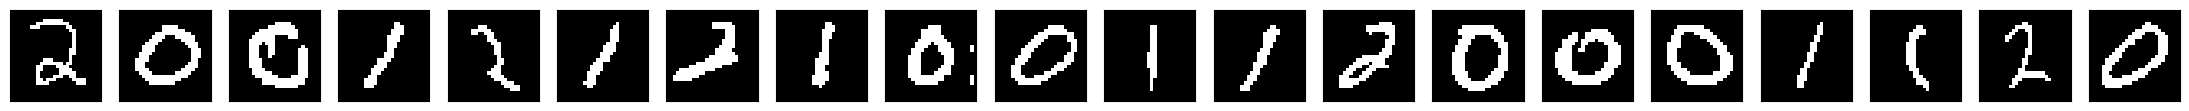

In [6]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [33]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [34]:
def plot_weights_bias(wE, bE, epoch, L, side=0,cols=0,thr=0,s=1.5, title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In Restricted Boltzmann Machines (RBMs), visible units can be represented as either Bernoulli (0/1) or Spin (-1/+1).  
To ensure consistent bias initialization across both cases, we normalize the activation proportion $ x_{\text{mean}} $ using:

$$
p_i = \frac{x_{\text{mean}} - x_{\min}}{x_{\max} - x_{\min}}
$$

This transformation ensures that $ p_i $ falls within the probability range $([0,1])$, preventing invalid logarithm calculations.  
The visible biases are then initialized as:

$$
a_i = \frac{1}{\text{level gap}} \log \left( \frac{p_i}{1 - p_i} \right)
$$

where:

$$
\text{level gap} = x_{\max} - x_{\min}
$$

So in the two cases we have
- Bernoulli (0/1):  
  $$
  x_{\min} = 0, \quad x_{\max} = 1 \quad \Rightarrow \quad \text{level gap} = 1
  $$
  $$
  a_i = \log \left( \frac{x_{\text{mean}}}{1 - x_{\text{mean}}} \right)
  $$

- Spin (-1/+1): 
  $$
  x_{\min} = -1, \quad x_{\max} = 1 \quad \Rightarrow \quad \text{level gap} = 2
  $$
  $$
  a_i = \frac{1}{2} \log \left( \frac{x_{\text{mean}} - (-1)}{1 - x_{\text{mean}}} \right)
  $$

  <br>

Given what just said, let's now proceed to explain the reason for this initialization by considering the Bernoulli case (0/1), in which $ a_i = \log \left( \frac{p_i}{1 - p_i} \right)$.

The probability of activation of a visible neuron in an RBM is given by:


$$
P(x_i=1∣h)=σ(a_i+\sum_{j}^{}W_{ij}h_j)
$$

where:

$$
σ(x)=\frac{1}{1+e^{-x}}
$$

If we initialize the weights to small values ($( W_{ij} \approx 0 )$), then the activation probability of a visible unit is approximately:

$$
P(v_i = 1) \approx \sigma(b_i)
$$

If we set:

$$
b_i = \log \left( \frac{p_i}{1 - p_i} \right)
$$

then we obtain:

$$
\sigma(b_i) = \frac{1}{1 + e^{-\log \left( \frac{p_i}{1 - p_i} \right) }} = p_i
$$

Thus, the initial probability that the neuron $ i $ is active will be exactly $ p_i $, which corresponds to the frequency with which the neuron is turned on in the training data, so this ensure this is a good initialization choice.

In [35]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

# Load Data

In [36]:
def LoadData(WhichData = None, WhichFolder = None, WhichModel = None,  KFold = False):

   if KFold == False:
      data_FileList = glob.glob(f"{WhichFolder}/{WhichData}_*") 

      # Load all files into a dictionary
      data = {fname: np.load(fname) for fname in data_FileList}

      #return only the values of the dictionary
      return data
   
   elif KFold:
      dataF = glob.glob(f"{WhichModel}_*") 
      data = [np.load(fname) for fname in dataF]

      #Returns the only element present with the same name
      return data[0]


# Data inizialization

In [169]:

def InitializeData(Ndigit):
   list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
   list_digits = list_10_digits[:Ndigit]
   print(list_digits)
   keep=np.isin(Y_original, list_digits)
   X_keep,Y=X_original[keep],Y_original[keep]
   data,label = MNIST_bit(X_keep),Y
   data,label = data.astype("int"),label.astype("int")

   return data, label

## Gradient descent method

In [38]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0, 0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05, 0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


# Saving file

In [39]:
def FileName(label, hp, FolderName, KFold = False, index = 0, time = None):
   #Label might be: a, b or w, logL
   #hyperparam: [#-if-digits, #-of-hidden-var, CDnumber, optimizr, l_rate_in, l_rate_fin, epochs, gamma, POTTS, SPINS ]

   fname = f'{FolderName}/{label}_RBM_{hp['Ndigit']}_{hp['L']}_{hp['Nt']}_{hp['Opt']}_{hp['l_rate_in']:.2f}-{hp['l_rate_fin']:.2f}_Ep{hp['epochs']}_Mini{hp['mini']}'
   if hp['gamma'] > 0: fname = fname + f'_reg{hp['gamma']:.3f}'
   if hp['POTTS']: fname = fname + f'_POTTS'
   if hp['SPINS']: fname = fname + f'_SPINS'
   fname = fname + f'__{index}'

   if KFold == False:
      fname = fname + f'_{time}' + '.npy'

   return fname

def SaveFile(label, hp, data, FolderName, time, index = 0):
   fname = FileName(label, hp, FolderName, time = time, index = index)

   np.save(fname, data)


# Log-likelihood $\mathcal{L}$ function

Allow to compute the log likelihood with the training data

In [40]:
import time
import numexpr as ne


def log_likelihood(a, b, w, data):
    
    Z_a = []
    exp_data_dip = []
    L = len(b)
    D = len(data[0])
    q = 1.4
    all_z = list(itertools.product([0, 1], repeat=L))

    #We already know the dimension of H
    OnesMat = np.ones(784) #Former was np.ones(len(H))

    for z in all_z:
        G = np.prod(np.exp(z * b))
        H = a + np.dot(w,z) 
        #q = np.mean(np.ones(len(H))+np.exp(H))
    
        Z_a.append(G * np.prod((OnesMat + np.exp(H))/q))

        
        #Ora voglio ciclare sulle x dei dati (i primi 1000 dati)
        ST2 = time.perf_counter()

        #Further optimization
        #exp_data_dip.append(np.sum(np.dot(data  H), axis = 0))
        exp_data_dip.append(np.einsum("ij,j->", data, H))

        ET2 = time.perf_counter()
        #print(f'Second time: {ET2 - ST2}') 


    #Z
    Z = np.sum(Z_a)
    log_Z = np.log(Z)+D*np.log(q)
    #log_first_part = np.log(np.sum(np.exp(exp_data_dip)))
    log_first_part = scipy.special.logsumexp(exp_data_dip)
    
    log_L = (log_first_part - log_Z)/D

    return log_L

# RBM train function


In [170]:
#'FolderName' is the folder in which we want to save the file: SingleTrain for this, BM_RandomSearch for the random search

def train_RBM(Hyperparams, FolderName, Debug = False, LL = True, LLPlot = False, BoolSaveFile = True, index=0): 

   #Only to check if the directory FolderName exist
   if os.path.isdir(FolderName):

      Ndigit = Hyperparams['Ndigit']
   
      L = Hyperparams['L']
      Nepoch = Hyperparams['epochs']
      Nt = Hyperparams['Nt']
      gamma = Hyperparams['gamma']
      l_rate_ini, l_rate_fin = Hyperparams['l_rate_in'], Hyperparams['l_rate_fin']
      GRAD = Hyperparams['Opt']
      POTTS, SPINS = Hyperparams['POTTS'], Hyperparams['SPINS']

      # minibatches per epoch
      Nmini = Hyperparams['mini']
      # minibatch size at initial epoch and final one
      N_ini, N_fin= 10, 400


      data, label = InitializeData(Ndigit)

      # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
      w = sigma * np.random.randn(D,L)
      #a = sigma * np.random.randn(D)
      # using Hinton initialization of visible biases
      a = Hinton_bias_init(data)
      # hidden biases initialized to zero
      b = np.zeros(L)

      # recording history of weights ("E" means epoch)
      wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
      wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
      gwE,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
      gaE,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
      gbE,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
      miniE = np.zeros(Nepoch+1)
      pzE=np.zeros((Nepoch+1,Nz))
      
      log_L_list = []


      if GRAD=="RMSprop": 
         gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)

      indices=np.arange(len(data)).astype("int")

      if Debug:
         plot_weights_bias(wE, aE, 0, L, cols=6, save=False)

      # for the plot with panels
      Ncols=min(8,max(2,L//2))

      if Debug:
         if POTTS: print("Starting the training, POTTS=True")

      # Note: here an epoch does not analyze the whole dataset
      for epoch in tqdm.tqdm(range(1,Nepoch+1)):
         # q maps epochs to interval [0,1]
         q = (epoch-1.)/(Nepoch-1.) 
         # N, size of the mini batch
         # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
         N = int(N_ini + (N_fin-N_ini)*(q**2))
         #  l_rate interpolates between initial and final value
         l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

         selected = np.random.choice(indices, N, replace=False)

         for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
            
            # Minibatch of size N: points randomply picked (without repetition) from data
            #if Debug:
               #if epoch==1 and mini<=3: print(selected)

            for k in range(N):
               ###################################
               x0 = data[selected[k]]
               # positive CD phase: generating z from x[k]
               
               z = CD_step(x0,w,b,POTTS=POTTS)
               x_data  += x0
               z_data  += z
               xz_data += np.outer(x0,z)
               # fantasy
               zf=np.copy(z)
               # Contrastive divergence with Nt steps
               for t in range(Nt):
                  # negative CD pzase: generating fantasy xf from fantasy zf
                  xf = CD_step(zf,w.T,a)
                  # positive CD phase: generating fantasy zf from fantasy xf 
                  zf = CD_step(xf,w,b,POTTS=POTTS)
               x_model += xf
               z_model += zf
               xz_model+= np.outer(xf,zf)
               # recording probability of encoding in z-space, if POTTS
               if POTTS: pz[zf]+=1
               ###################################
            
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)


            
            # gradient ascent step
            if GRAD=="RMSprop":
               # RMSprop gradient ascent
               gw2 = beta*gw2+(1-beta)*np.square(gw)
               ga2 = beta*ga2+(1-beta)*np.square(ga)
               gb2 = beta*gb2+(1-beta)*np.square(gb)
               w += l_rate*gw/sqrt(epsilon+gw2)
               a += l_rate*ga/sqrt(epsilon+ga2)
               b += l_rate*gb/sqrt(epsilon+gb2)

            else: 
               # defaulting to the vanilla stochastic gradient ascent (SGD)
               w += l_rate*gw
               a += l_rate*ga
               b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
               w -= (gamma*l_rate)*sign(w)
               a -= (gamma*l_rate)*sign(a)
               b -= (gamma*l_rate)*sign(b)

         wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
         aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
         bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
         miniE[epoch]=N

         #Computing the likelihood
         if LL:
            log_L = log_likelihood(a, b, w, data)
            log_L_list.append(log_L)

         if POTTS: pzE[epoch] = pz/np.sum(pz)
         # if Debug: 
         #    print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
         #          " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
      
         str_time = datetime.datetime.now().strftime("_%m%d_%H%M")

      if Debug:
         plot_weights_bias(wE, aE, epoch, L, cols=6, save=False)


      if BoolSaveFile:
         SaveFile('w', Hyperparams, wE, FolderName, time = str_time, index=index)
         SaveFile('b', Hyperparams, bE, FolderName, time = str_time, index=index)
         SaveFile('a', Hyperparams, aE, FolderName, time = str_time, index=index)
         #SaveFile('logL', str_time, Hyperparams, log_L_list, FolderName)

      if LLPlot:

         LogLike = log_L_list[-30:]

         #To have an array of the same dimension of x
         MeanLL = np.full((30,), np.mean(LogLike))

         LLlinspace = np.arange(Nepoch - 30, Nepoch, 1)

         plt.figure(figsize=(10, 6))
         plt.plot(range(Nepoch), log_L_list, label=r"$\log \mathcal{L}$")
         plt.plot(LLlinspace, MeanLL, linestyle='dashed', color="red", label=r"$\langle\mathcal{\log L}\rangle \pm \sigma_{\mathcal{L}}$")
         plt.fill_between(LLlinspace, MeanLL - np.std(LogLike), MeanLL + np.std(LogLike), color='red', alpha=0.3, )

         plt.title("log-Likehood trend")  # Titolo
         plt.xlabel("# epoch")  # Etichetta asse X
         plt.ylabel(r"$\log \mathcal{L}$")  # Etichetta asse Y
         plt.grid(True)  # Aggiunge una griglia
         plt.legend()
         plt.show()


      if LL: 
         return np.mean(log_L_list[-30:]), np.std(log_L_list[-30:])

   else:
      print("Directory does not exist")


{'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}
('0', '1', '2')
dataset with 21770 points, each with 784 bits



<Figure size 640x480 with 0 Axes>

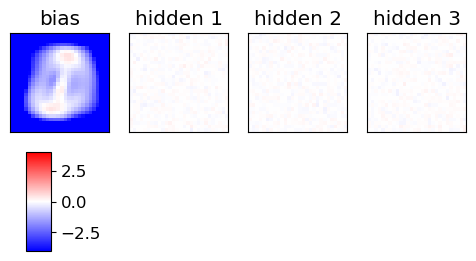

100%|██████████| 150/150 [00:58<00:00,  2.57it/s]


<Figure size 640x480 with 0 Axes>

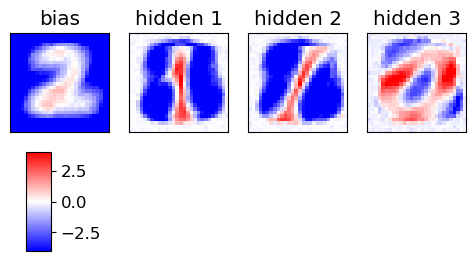

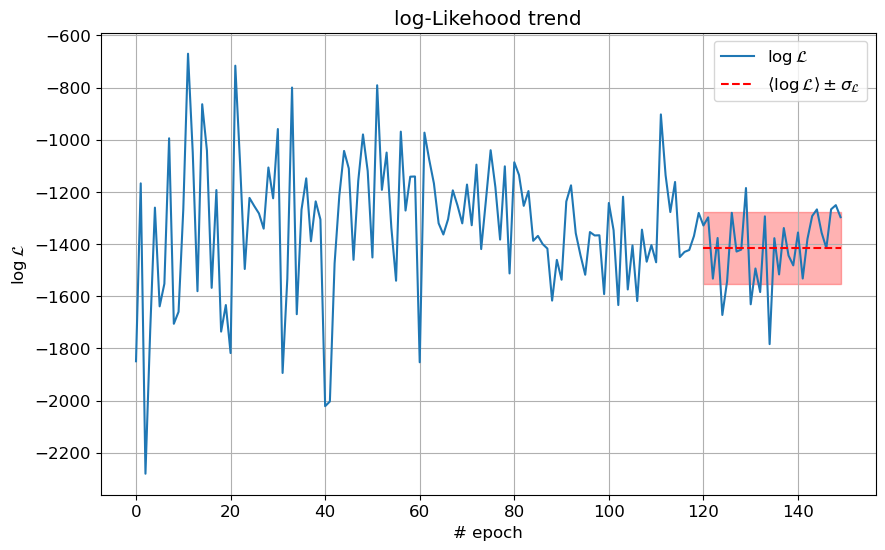

In [50]:
DefaultHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}
print(DefaultHyperp)
LLmean, LLstd = train_RBM(DefaultHyperp, FolderName = 'SingleTrain', Debug = True, LL = True, LLPlot=True, BoolSaveFile=True)

# Verify how $\mathcal{L}$ changes with L and CD

In [17]:
TestHyperp = {'Ndigit': 3, 'L': 3, 'Nt': 2, 
                 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 175, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

L_range = [1, 2, 3, 4, 5, 6, 7, 8]
Nt_range = [2, 3, 4, 5, 6, 7, 8, 9]


#Run time: 6hr
# TestLogLik, stdLL = np.zeros((len(L_range), len(Nt_range))), np.zeros((len(L_range), len(Nt_range)))

# for i, l in enumerate(L_range):
#    for j, nt in enumerate(Nt_range):
#       TestHyperp.update({'L': l, 'Nt': nt})
#       LLMean, LLstd = train_RBM(TestHyperp, data, 'TestTrain', Debug = False, LL = True, LLPlot = False, BoolSaveFile=False)
#       TestLogLik[i][j] = LLMean
#       stdLL[i][j] = LLstd



# np.save('TestLogLik1.npy', TestLogLik)
# np.save('stdLL1.npy', stdLL)

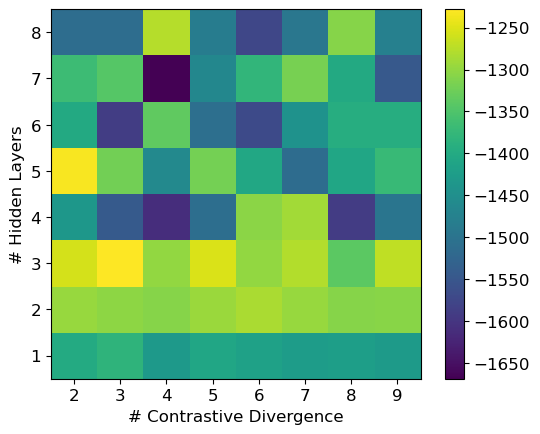

In [18]:
TestLogLik = np.load('TestLogLik.npy')
stdLL = np.load('stdLL.npy')

#print(stdLL)

plt.imshow(TestLogLik)
plt.gca().invert_yaxis()
plt.colorbar()

x, y = np.meshgrid(np.arange(2), np.arange(2))
#plt.scatter(x, y, color='white', s=10)  # Small dots at each point
#plt.errorbar(x.ravel(), y.ravel(), yerr=stdLL.ravel(), fmt='none', ecolor='white', alpha=0.8)
plt.xticks(ticks=np.arange(0, len(Nt_range)), labels=np.arange(2, len(L_range) + 2))
plt.yticks(ticks=np.arange(0, len(L_range)), labels=np.arange(1, len(L_range) + 1))
plt.xlabel("# Contrastive Divergence")
plt.ylabel("# Hidden Layers")


plt.show()


# Implementing the Search

In [19]:
HP = {'L': [1, 6], 
      'Nt': [2, 6], 
      'Opt': ['RMSprop', 'SGD'],
      'l_rate_in': [1, 0.1], 
      'l_rate_fin': [0.1, 0.05],  
      'mini': [10, 41],
      'gamma': [0.1, 0.001], 
      #'POTTS': [False, True], 
      #'SPINS': False
      }

#Myabe we could try to implement a bayesian optimization
def RandomSearch(HP, Ndigit = 3, nModels = 10):

   HyperParams_List = []

   for _ in range(nModels):

      L, Nt = np.random.randint(HP['L'][0], HP['L'][1]), np.random.randint(HP['Nt'][0], HP['Nt'][1] )
      l_rate_in = np.round(np.random.uniform(HP['l_rate_in'][0], HP['l_rate_in'][1]), 4)
      l_rate_fin = np.round(np.random.uniform(HP['l_rate_fin'][0], HP['l_rate_fin'][1]), 4)
      mini = np.random.choice(range(HP['mini'][0], HP['mini'][1], 5))
      gamma = np.round(np.random.uniform(HP['gamma'][0], HP['gamma'][1]), 4)

      Opt = np.random.choice(HP['Opt'])

      HyperParams = {'Ndigit': Ndigit, 'L': L, 'Nt': Nt, 'Opt': Opt, 'l_rate_in': l_rate_in, 
                     'l_rate_fin': l_rate_fin, 'epochs': 175, 'mini': mini, 'gamma': gamma, 'POTTS': False, 'SPINS': False}

      HyperParams_List.append(HyperParams)

   return HyperParams_List


In [51]:
HyperParam_List = RandomSearch(HP, nModels = 5)

# Training with all the Models

{'Ndigit': 3, 'L': 3, 'Nt': 3, 'Opt': 'SGD', 'l_rate_in': 0.9699, 'l_rate_fin': 0.0723, 'epochs': 175, 'mini': 30, 'gamma': 0.01, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [01:53<00:00,  1.54it/s]


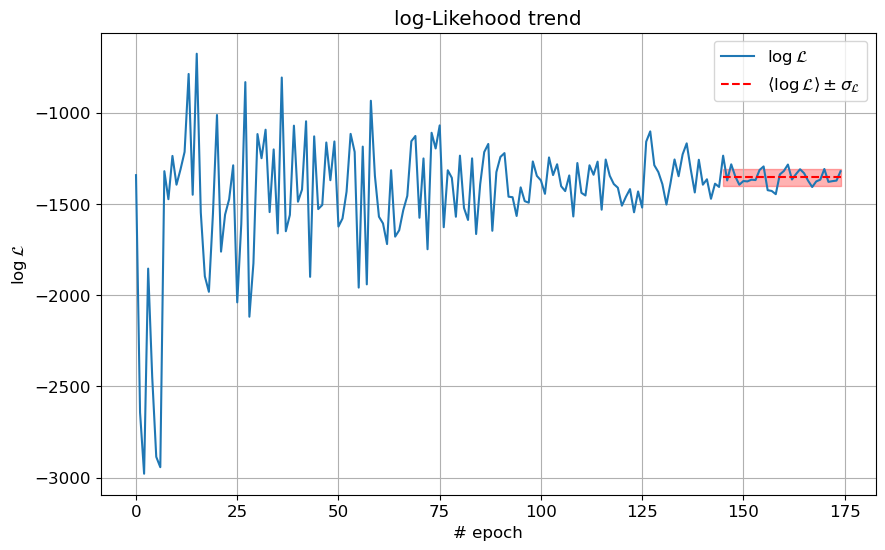

{'Ndigit': 3, 'L': 2, 'Nt': 4, 'Opt': 'RMSprop', 'l_rate_in': 0.1295, 'l_rate_fin': 0.0929, 'epochs': 175, 'mini': 30, 'gamma': 0.0632, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [01:52<00:00,  1.56it/s]


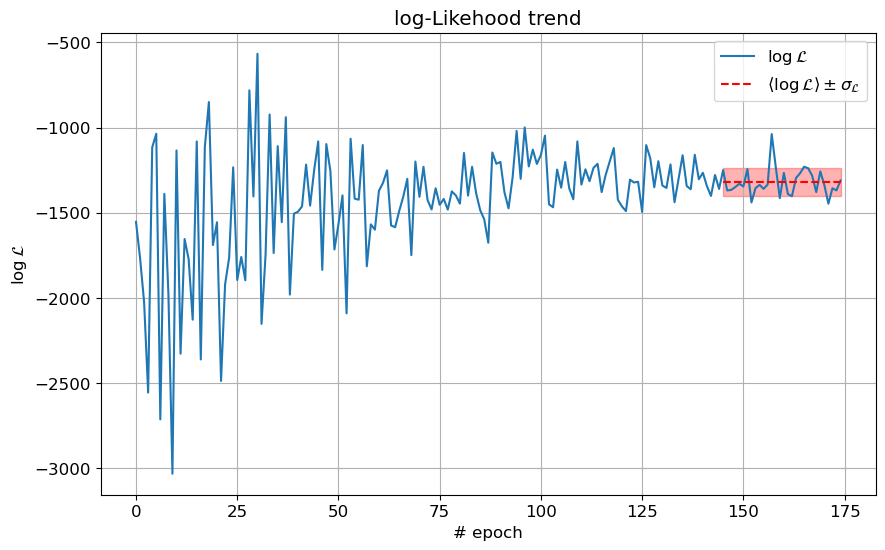

{'Ndigit': 3, 'L': 4, 'Nt': 4, 'Opt': 'RMSprop', 'l_rate_in': 0.5505, 'l_rate_fin': 0.072, 'epochs': 175, 'mini': 40, 'gamma': 0.0366, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [02:57<00:00,  1.01s/it]


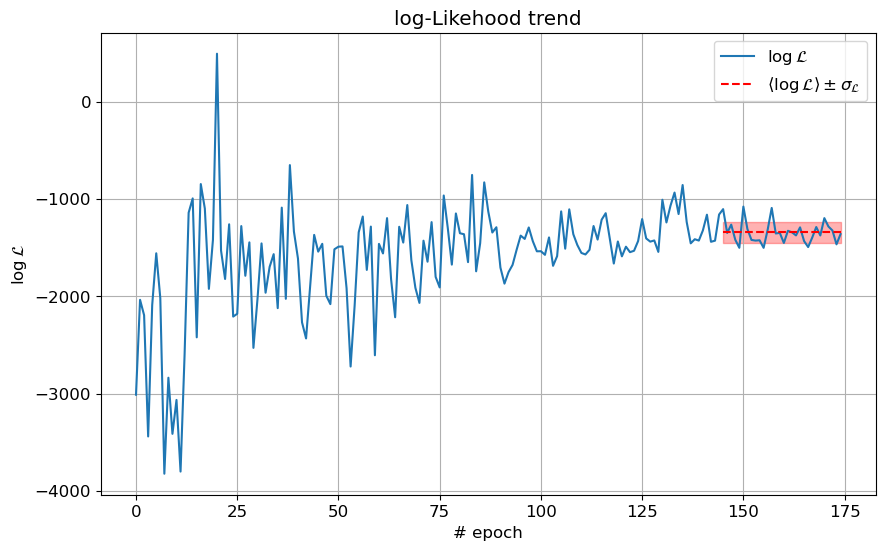

{'Ndigit': 3, 'L': 2, 'Nt': 3, 'Opt': 'RMSprop', 'l_rate_in': 0.8086, 'l_rate_fin': 0.0525, 'epochs': 175, 'mini': 20, 'gamma': 0.0961, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [01:05<00:00,  2.69it/s]


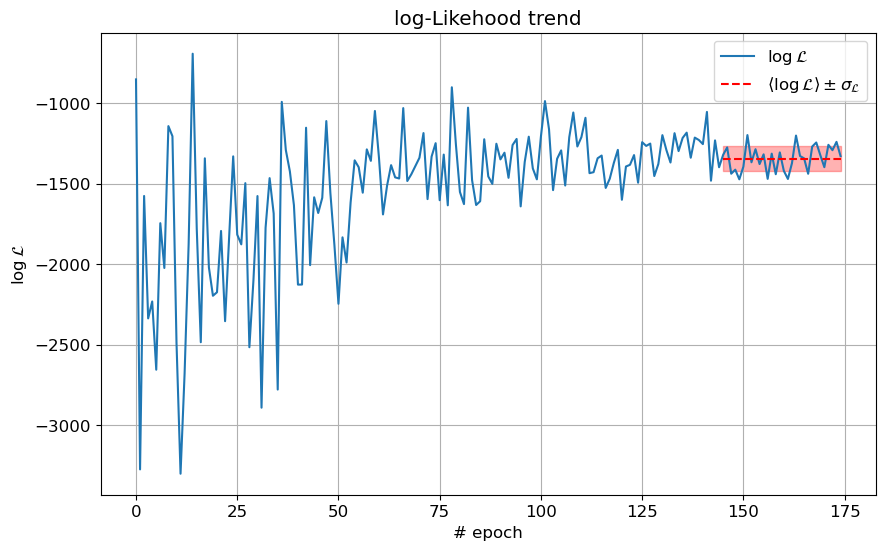

{'Ndigit': 3, 'L': 2, 'Nt': 3, 'Opt': 'SGD', 'l_rate_in': 0.2775, 'l_rate_fin': 0.0785, 'epochs': 175, 'mini': 40, 'gamma': 0.0324, 'POTTS': False, 'SPINS': False}


100%|██████████| 175/175 [01:59<00:00,  1.46it/s]


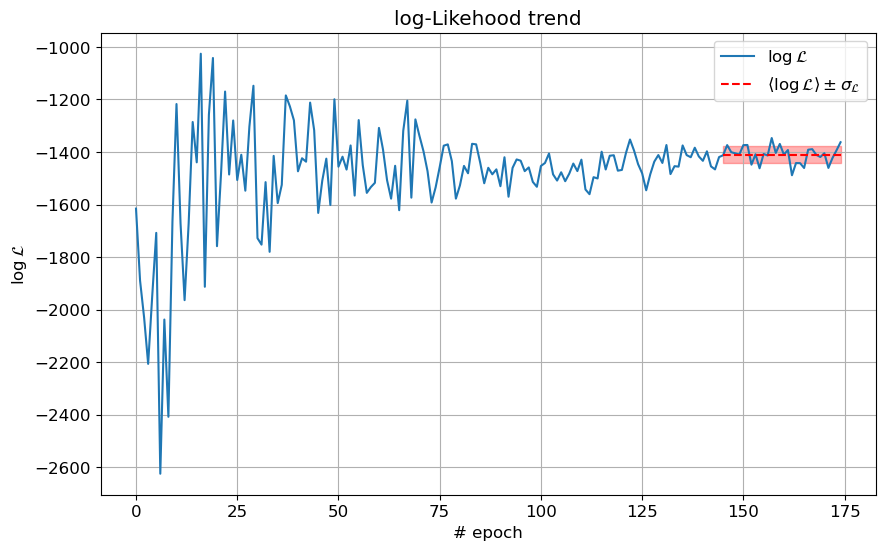

In [52]:
ResultDict = {}

for hyperparams in HyperParam_List:
   print(hyperparams)
   mean, std = train_RBM(hyperparams, data, FolderName = 'BM_RandomSearch', Debug = False, LL = True, LLPlot=True, BoolSaveFile=False)
   ResultDict[f'{hyperparams}'] = (mean, std)

# Just to explain, to be deleted

In [22]:
ResultDict

{"{'Ndigit': 3, 'L': 5, 'Nt': 5, 'Opt': 'RMSprop', 'l_rate_in': 0.6347, 'l_rate_fin': 0.0678, 'epochs': 175, 'mini': 15, 'gamma': 0.0726, 'POTTS': False, 'SPINS': False}": (-1424.9294780863413,
  132.5959639656026),
 "{'Ndigit': 3, 'L': 1, 'Nt': 4, 'Opt': 'SGD', 'l_rate_in': 0.6502, 'l_rate_fin': 0.0723, 'epochs': 175, 'mini': 35, 'gamma': 0.0583, 'POTTS': False, 'SPINS': False}": (-1219.261869432444,
  33.85751918927822)}

In [23]:
#Allow to retrieve the hyperparameters from the dictionary created before
def OrderingModels(Dictionary):
   Dict = dict(sorted(Dictionary.items(), key=lambda item: item[1], reverse=True))
   return [ast.literal_eval(key) for key in Dict.keys()]


OrderedResultDict = OrderingModels(ResultDict)
OrderedResultDict[:3]

[{'Ndigit': 3,
  'L': 1,
  'Nt': 4,
  'Opt': 'SGD',
  'l_rate_in': 0.6502,
  'l_rate_fin': 0.0723,
  'epochs': 175,
  'mini': 35,
  'gamma': 0.0583,
  'POTTS': False,
  'SPINS': False},
 {'Ndigit': 3,
  'L': 5,
  'Nt': 5,
  'Opt': 'RMSprop',
  'l_rate_in': 0.6347,
  'l_rate_fin': 0.0678,
  'epochs': 175,
  'mini': 15,
  'gamma': 0.0726,
  'POTTS': False,
  'SPINS': False}]

In [24]:
a_fileName = FileName('w', hp = OrderedResultDict[0], FolderName='KFoldCV', KFold=True, index = 0)
a_fileName

'KFoldCV/w_RBM_3_1_4_SGD_0.65-0.07_Ep175_Mini35_reg0.058__0'

# K fold cross Validation

In [57]:
from sklearn.model_selection import KFold

def OrderingModels(Dictionary):
   Dict = dict(sorted(Dictionary.items(), key=lambda item: item[1], reverse=True))
   return [ast.literal_eval(key) for key in Dict.keys()]

def KFoldCV_RBM(data, Dictionary, HowManyBestModel = 3):

   KFolds = KFold(n_splits = 2, shuffle=True)
   #In this way i retrieve only the hyperparameters
   OrderedDictionary = OrderingModels(Dictionary)


   LL_AllModels = []

   for model, hp in enumerate(OrderedDictionary[:HowManyBestModel], start = 1):

      print(f'K Fold of the {model}° model: ')

      LLfold = []
      for i, (train_I, test_I) in enumerate(KFolds.split(data)):

         print(f'Analizing the {i+1}° fold: ')

         #Train the kfold model with the train data
         train_RBM(hp, data[train_I], FolderName='KFoldCV', Debug = False, LLPlot = False, LL = False, BoolSaveFile=True, index=i)

         LL = []


         #from the hyperparameter used retrieve the name of the file
         a_fileName = FileName('a', hp, FolderName='KFoldCV', KFold=True, index = i)
         b_fileName = FileName('b', hp, FolderName='KFoldCV', KFold=True, index = i)
         w_fileName = FileName('w', hp, FolderName='KFoldCV', KFold=True, index = i)

         #Load the file
         a_data = LoadData(WhichFolder = 'KFoldCV', WhichModel = a_fileName, KFold = True)
         b_data = LoadData(WhichFolder = 'KFoldCV', WhichModel = b_fileName, KFold = True)
         w_data = LoadData(WhichFolder = 'KFoldCV', WhichModel = w_fileName, KFold = True)

         for epoch in range(hp['epochs']):

            ll = log_likelihood(a_data[epoch], b_data[epoch], w_data[epoch], data[test_I])

            LL.append(ll)

         LLfold.append(np.mean(LL[-30:]))

      
      print('-------------------------------------------------------')

      LL_AllModels.append((np.mean(LLfold), np.std(LLfold)))

   print('\n')
   print(f'The score of the {HowManyBestModel} models analized are the following: (mean, std)')
   print(LL_AllModels)

   #All the model analized from best to worst and the hyperparameters of the best model
   ArgMax = max(range(len(LL_AllModels)), key=lambda i: LL_AllModels[i][0])
   LL_AllModelsOrdered = sorted(LL_AllModels, key=lambda item: item[1], reverse=True)


   return LL_AllModelsOrdered, OrderedDictionary[ArgMax]


In [58]:
LL_AllModels, BestModel = KFoldCV_RBM(data, ResultDict, HowManyBestModel=5)

K Fold of the 1° model: 
Analizing the 1° fold: 


  0%|          | 0/175 [00:00<?, ?it/s]

100%|██████████| 175/175 [01:41<00:00,  1.72it/s]


Analizing the 2° fold: 


100%|██████████| 175/175 [01:38<00:00,  1.77it/s]


-------------------------------------------------------
K Fold of the 2° model: 
Analizing the 1° fold: 


100%|██████████| 175/175 [00:52<00:00,  3.31it/s]


Analizing the 2° fold: 


100%|██████████| 175/175 [00:53<00:00,  3.29it/s]


-------------------------------------------------------
K Fold of the 3° model: 
Analizing the 1° fold: 


100%|██████████| 175/175 [02:09<00:00,  1.35it/s]


Analizing the 2° fold: 


100%|██████████| 175/175 [02:09<00:00,  1.35it/s]


-------------------------------------------------------
K Fold of the 4° model: 
Analizing the 1° fold: 


100%|██████████| 175/175 [01:28<00:00,  1.98it/s]


Analizing the 2° fold: 


100%|██████████| 175/175 [01:31<00:00,  1.92it/s]


-------------------------------------------------------
K Fold of the 5° model: 
Analizing the 1° fold: 


100%|██████████| 175/175 [01:50<00:00,  1.58it/s]


Analizing the 2° fold: 


100%|██████████| 175/175 [01:50<00:00,  1.58it/s]


-------------------------------------------------------


The score of the 5 models analized are the following: (mean, std)
[(117.66847707698247, 764.9220400944089), (-39.512379087613226, 608.0981773592065), (-757.2573794286754, 74.9508754125988), (-728.6447642448916, 27.858504743129686), (-690.2618743243329, 38.539738160545596)]


In [60]:
LL_AllModels

[(117.66847707698247, 764.9220400944089),
 (-39.512379087613226, 608.0981773592065),
 (-757.2573794286754, 74.9508754125988),
 (-690.2618743243329, 38.539738160545596),
 (-728.6447642448916, 27.858504743129686)]

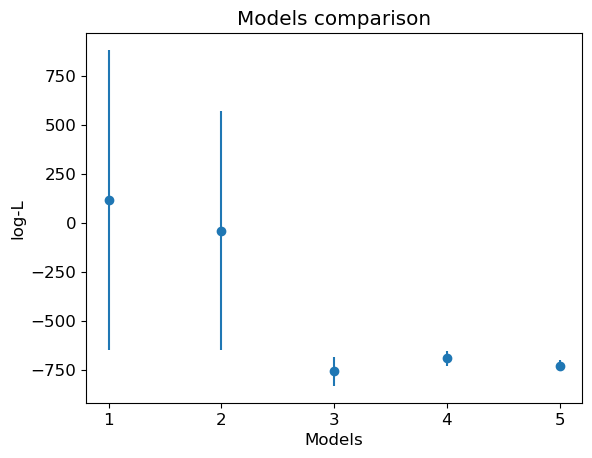

In [59]:
x = np.arange(len(LL_AllModels))
y = [t[0] for t in LL_AllModels]
erry = [t[1] for t in LL_AllModels]

plt.errorbar(x, y, yerr = erry, fmt='o')
plt.ylabel("log-L")
plt.xlabel("Models")
plt.title("Models comparison")
plt.xticks(ticks=np.arange(0, len(x)), labels=np.arange(1, len(x)+1))
plt.show()

## Test generative power of the trained RBM

In [58]:
aE = LoadData('a', 'SingleTrain')


list(aE.values())[0]

array([[ -9.2102,  -9.2102,  -9.2102, ...,  -9.2102,  -9.2102,  -9.2102],
       [ -9.2092,  -9.2092,  -9.2092, ...,  -9.2092,  -9.2092,  -9.2092],
       [ -9.2082,  -9.2082,  -9.2082, ...,  -9.2082,  -9.2082,  -9.2082],
       ...,
       [ -9.8401,  -9.8967,  -9.8411, ..., -10.1687,  -9.7737, -10.0046],
       [ -9.8517,  -9.8957,  -9.8527, ..., -10.1677,  -9.7727, -10.0163],
       [ -9.8507,  -9.9072,  -9.8517, ..., -10.1667,  -9.7717, -10.0153]])

<Figure size 640x480 with 0 Axes>

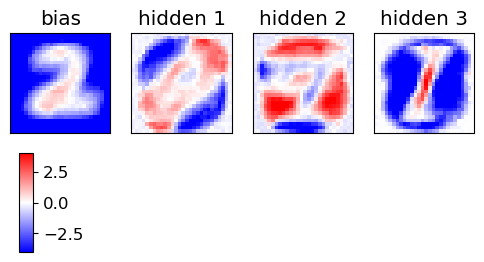

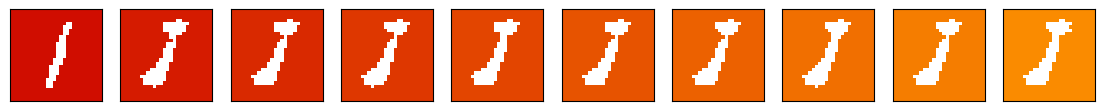

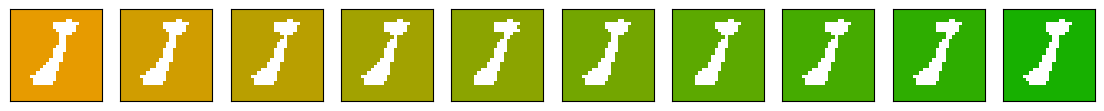

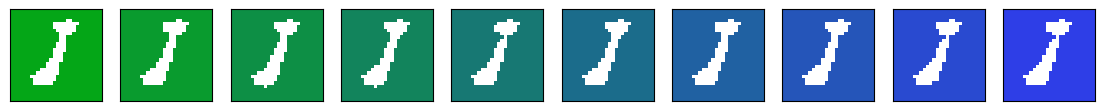

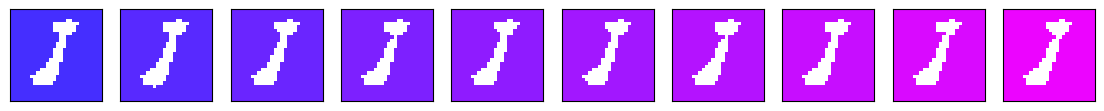

L: 3     amplification of weights: 10.0


In [59]:
#Loading all the file in the folder and, from all, take the last one (chronologically)
aE = list(LoadData('a', 'SingleTrain').values())[-1]
bE = list(LoadData('b', 'SingleTrain').values())[-1]
wE = list(LoadData('w', 'SingleTrain').values())[-1]




ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=10.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, 150, L, cols=3, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF )

## Plot of the gradient amplitude

In [ ]:
NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

# 4) Hidden state activation

We want now to visualize the distribution of the activated hidden states. We firstly visualize for a simple RMB with just 3 digits (0, 1, 2) and only 3 hidden states. Then we visualize the same distribution but with all 10 numbers from the MNIST and 5 hidden states

In [237]:
def HiddenStateAct(Nc, HyperP, aE, bE, wE, xAxis, ImSize):

    Ndigit = HyperP['Ndigit']
    L = HyperP['L']

    nRows = Ndigit // 3 if Ndigit % 3 == 0 else Ndigit // 3 + 1
    data, label = InitializeData(Ndigit)

    digits = [data[label == i] for i in range(Ndigit)] # "shape" (L, N, 784)
    fig, axes = plt.subplots(nRows, 3, figsize=ImSize)

    z_Nf_freq, States = [], []

    # generalize to arbitrary number of plots

    for i in range(Ndigit):
        # x_cd = np.zeros((Nc, len(digits[i]), L))
        x_f = digits[i]          # shape (N, 784)
        z_cd = np.zeros((Nc, len(digits[i]), L))

        for j in range(Nc):
            z_cd[j] = [CD_step(digit, wE[-1], bE[-1]) for digit in x_f]
            x_f     = [CD_step(zeta, wE[-1].T, aE[-1]) for zeta in z_cd[j]]

        #z_0_activated = [str(state).replace(".", "") for state in z_cd[0]]  # These are the hidden states activated directly by images
        z_Nf_activated = [str(state).replace(".", "") for state in z_cd[-1]]

        #z_0_occurrences = Counter(z_0_activated)        # {(0,0,1): 4, (1,0,1): 10, ...}
        z_Nf_occurrences = Counter(z_Nf_activated) 

        #print(z_0_occurrences)
        #print(z_Nf_occurrences)

        states = list(map(lambda s: str(s).replace(",", "").replace("(", "[").replace(")", "]"), itertools.product([0, 1], repeat=L)))  # I need [0 0 0] format goddammit
        States.append(states)
        #z_0_frequencies = [z_0_occurrences[state] for state in states]
        z_Nf_frequencies= [z_Nf_occurrences[state] for state in states]
        z_Nf_freq.append(z_Nf_frequencies)




    z_Nf_freq = np.reshape(np.array(z_Nf_freq), (nRows, 3, -1))
    States = np.reshape(np.array(States), (nRows, 3, -1))

    if nRows > 1:
        digit = 0
        for t in range(nRows):
            for k in range(3):

                #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
                axes[t][k].bar(States[t][k], z_Nf_freq[t][k], fill=False, hatch='/', edgecolor='orange', label=f'Activated at step {Nc}')

                if xAxis == False: 
                    axes[t][k].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axes[t][k].title.set_text(f"Digit {digit} activated states")
                axes[t][k].legend()
                axes[t][k].set_xlabel("Possible States")
                axes[t][k].set_ylabel("Counts")

                digit += 1

    else:

        for i in range(3):
            #axes[i].bar(states, z_0_frequencies, fill=False, hatch='.', edgecolor='purple', label=f'Activated by image')
            axes[i].bar(States[0][i], z_Nf_freq[0][i], fill=False, hatch='/', edgecolor='orange', label=f'Activated at step {Nc}')

            if xAxis == False: 
                axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

            axes[i].title.set_text(f"Digit {i}")
            axes[i].legend()
            axes[i].set_xlabel("Possible States")
            axes[i].set_ylabel("Counts")

    fig.tight_layout()  # Automatically adjusts spacing
    plt.show()
    plt.close()
    

In [220]:
HiddenStateActHyperP1 = {'Ndigit': 3, 'L': 3, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

#train_RBM(HiddenStateActHyperP1, FolderName='TestTrain', Debug = False, LL = False, LLPlot=False, BoolSaveFile=True )

('0', '1', '2')
dataset with 21770 points, each with 784 bits



100%|██████████| 150/150 [00:40<00:00,  3.68it/s]


('0', '1', '2')
dataset with 21770 points, each with 784 bits



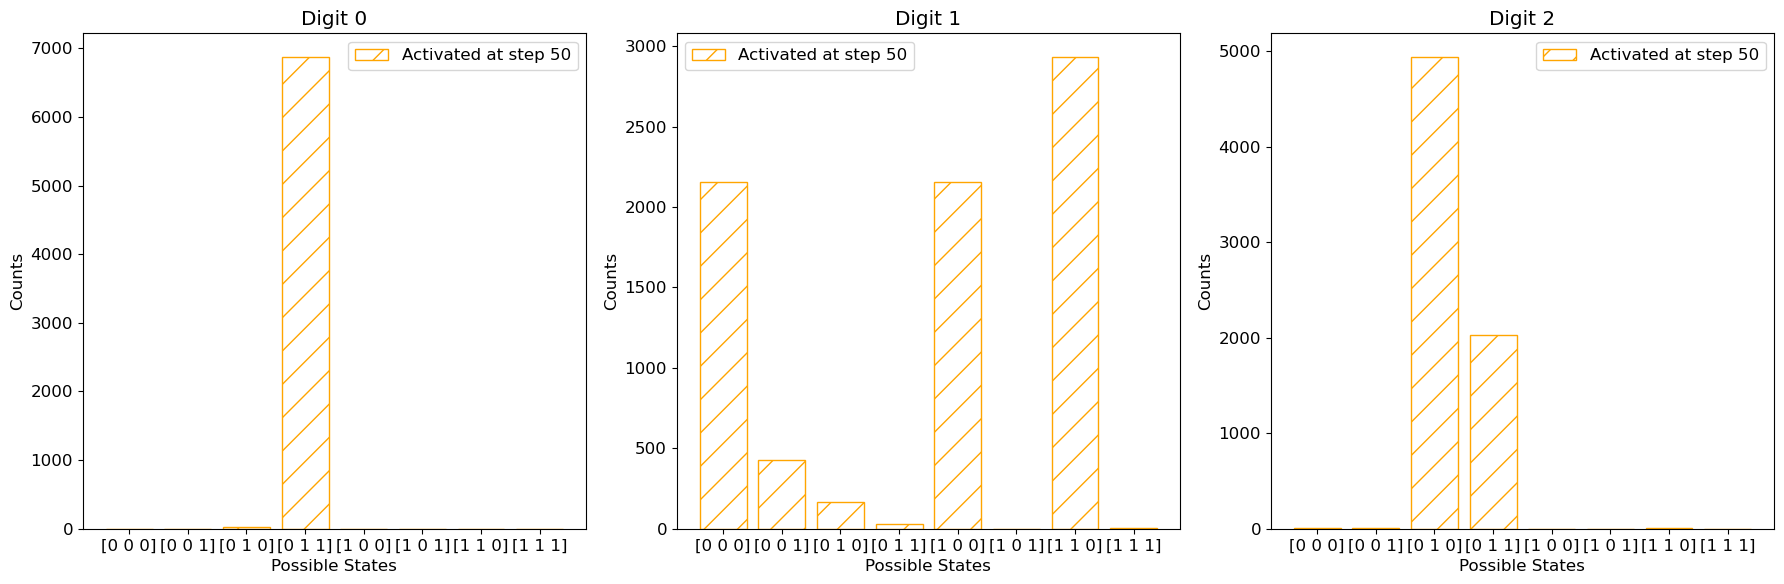

In [223]:
aE = np.load('TestTrain/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
bE = np.load('TestTrain/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
wE = np.load('TestTrain/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')

HiddenStateAct(50, HiddenStateActHyperP1, aE, bE, wE, xAxis = True, ImSize = (18, 6))

And now for the bigger model:

In [235]:
HiddenStateActHyperP2 = {'Ndigit': 9, 'L': 10, 'Nt': 2, 'Opt': 'RMSprop', 'l_rate_in': 0.05, 'l_rate_fin': 0.05, 'epochs': 150, 'mini': 20, 'gamma': 0.001, 'POTTS': False, 'SPINS': False}

#train_RBM(HiddenStateActHyperP2, FolderName='TestTrain', Debug = False, LL = False, LLPlot=False, BoolSaveFile=True )

('0', '1', '2', '3', '4', '5', '6', '7', '8')
dataset with 63042 points, each with 784 bits



100%|██████████| 150/150 [00:44<00:00,  3.39it/s]


('0', '1', '2', '3', '4', '5', '6', '7', '8')
dataset with 63042 points, each with 784 bits



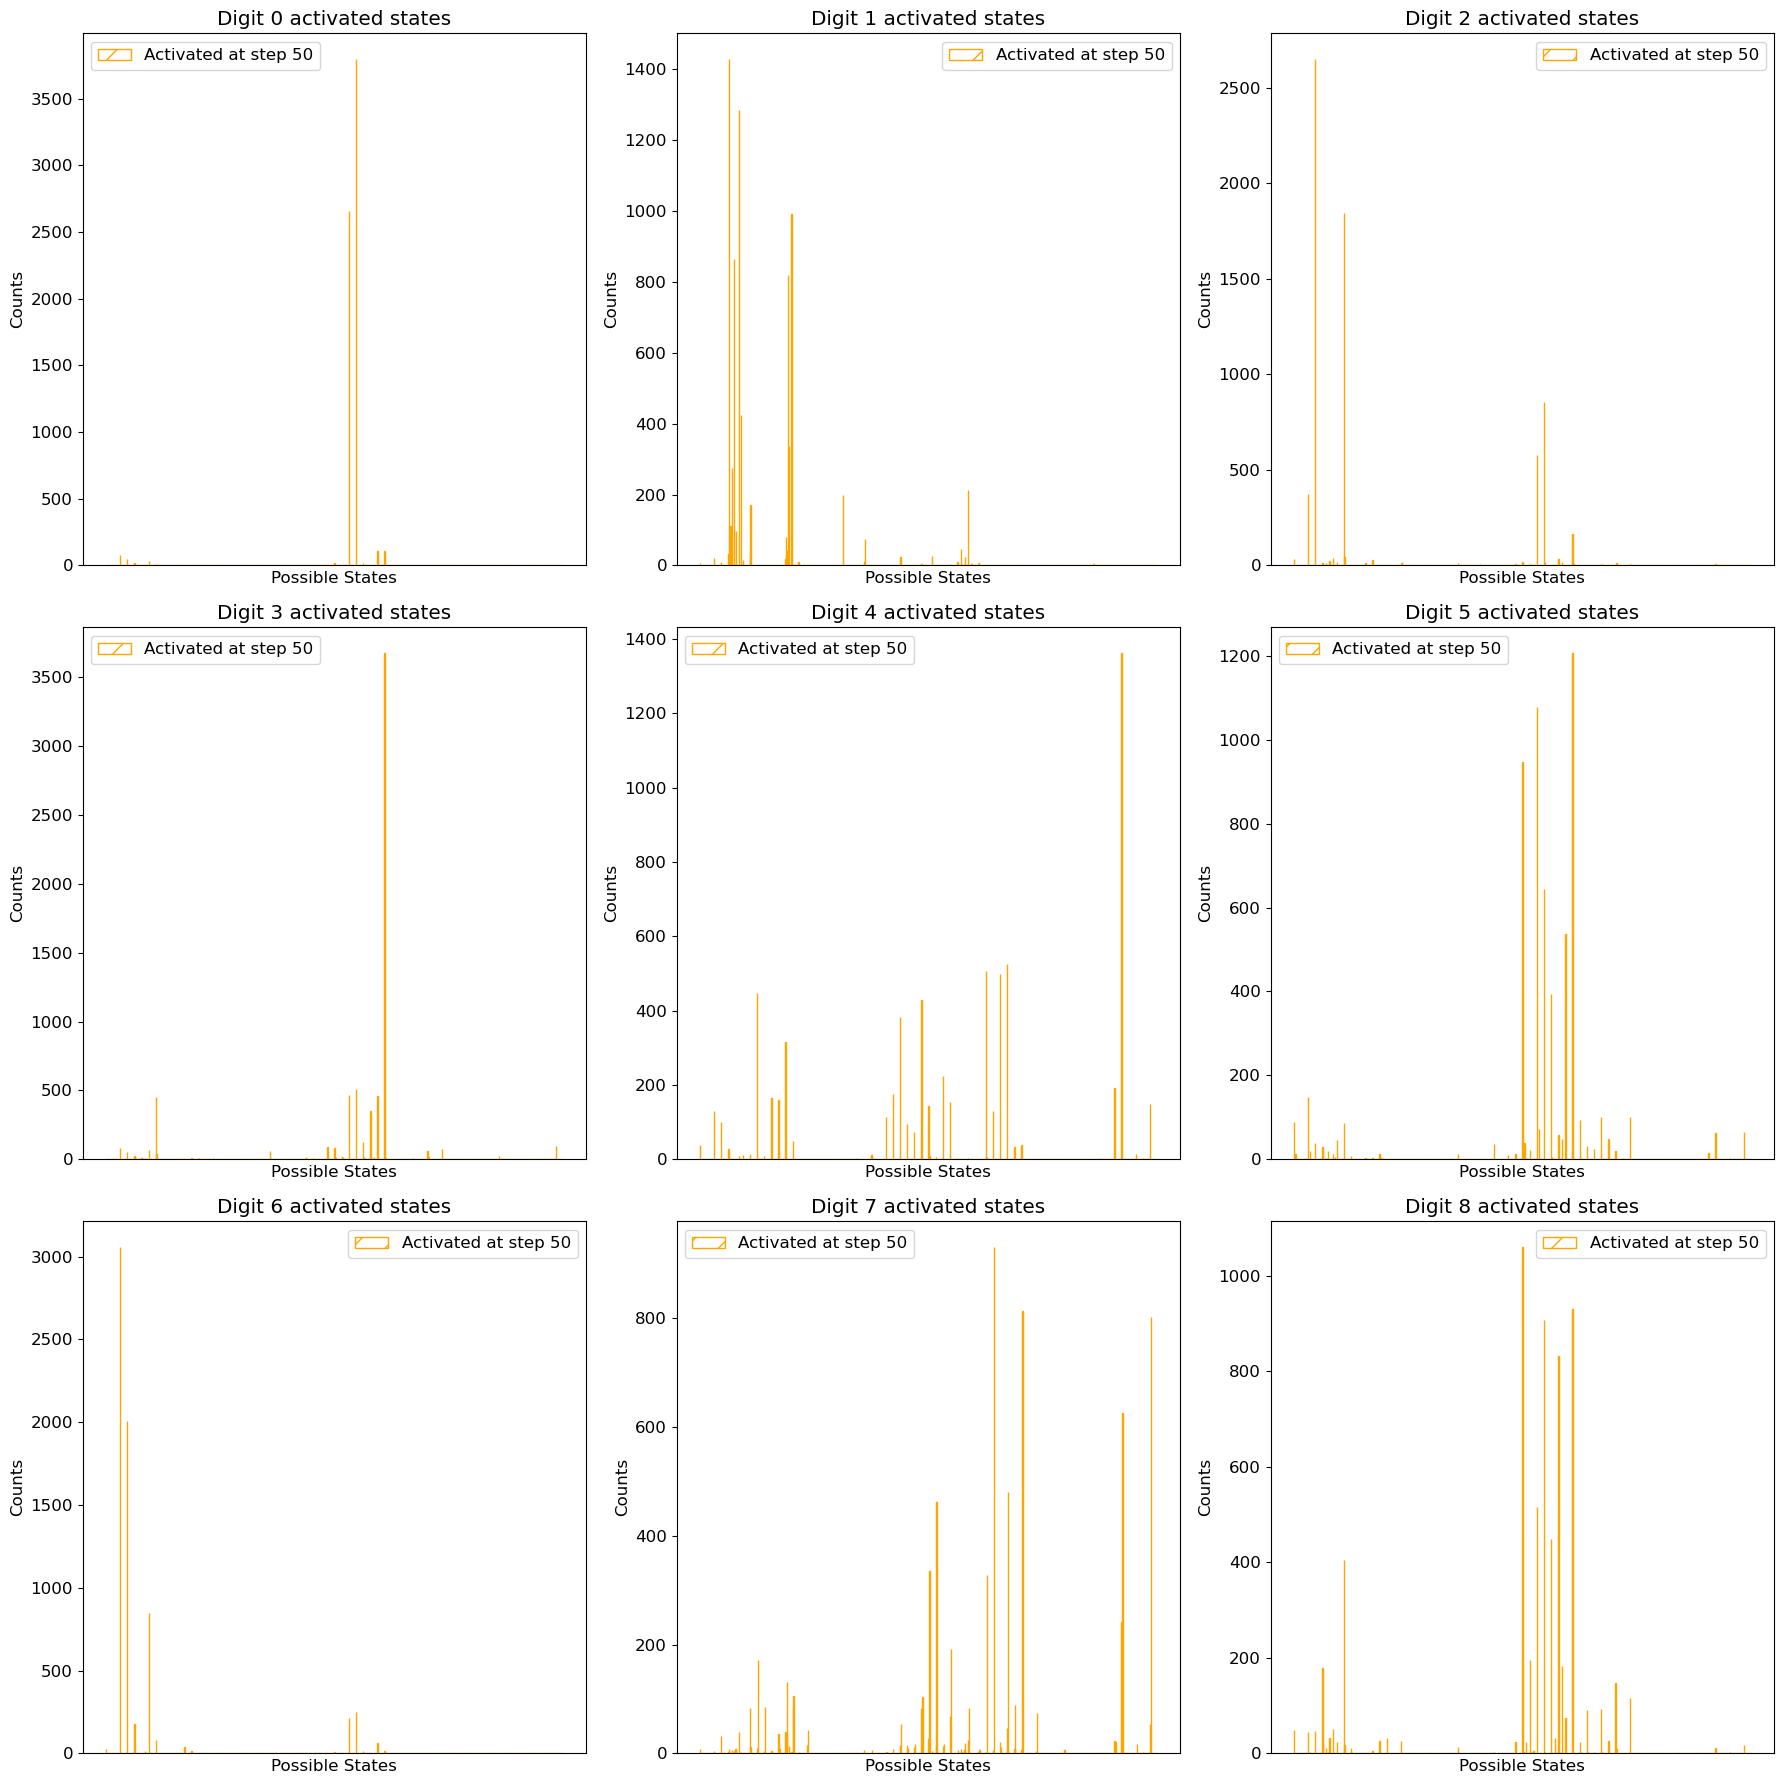

In [240]:
aE = np.load('TestTrain/a_RBM_9_10_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1832.npy')
bE = np.load('TestTrain/b_RBM_9_10_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1832.npy')
wE = np.load('TestTrain/w_RBM_9_10_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1832.npy')

HiddenStateAct(50, HiddenStateActHyperP2, aE, bE, wE, xAxis = False, ImSize = (18, 18))

# codice di Marco 

In [260]:
def EnergyBarrier(aE, bE, wE, ShowBarrier):
    W = wE[-1]
    a = aE[-1]
    b = bE[-1]

    selectA = 1
    selectB = 2
    index_selectA = np.random.choice( np.where(label == selectA)[0] )
    index_selectB = np.random.choice( np.where(label == selectB)[0] )
    dataA = data[index_selectA]
    dataB = data[index_selectB]

    zA = CD_step(dataA,W,b)
    zB = CD_step(dataB,W,b)

    def energy(x, z, W, a, b):
        return -(np.dot(x, a) + np.dot(z, b) + np.dot(x, np.dot(W , z)))

    n_steps = 150
    energies = []
    intermediate_images = []

    for alpha in np.linspace(0, 1, n_steps):

        if ShowBarrier:
            # PART SHOW BARRIER
            x_intermediate = (1 - alpha) * dataA + alpha * dataB  # Interpolazione lineare
            x_intermediate = (x_intermediate > 0.5).astype(int)  # Soglia binaria
            z_intermediate = CD_step(x_intermediate, W, b,)

            E = energy(x_intermediate, z_intermediate, W, a, b)
            energies.append(E)
            intermediate_images.append(x_intermediate.reshape(28, 28))
            # ----------------------

        else:
            # PART OVERCOME BARRIER
            x_intermediate = np.zeros(D)
            #ora per ogni pixel, decido con la soglia random se prendere il valore da dataA o da dataB
            for i in range(D):
                if np.random.uniform() > alpha:
                    x_intermediate[i] = dataA[i]
                else:
                    x_intermediate[i] = dataB[i]

                z_intermediate = CD_step(x_intermediate, W, b,)

            E = energy(x_intermediate, z_intermediate, W, a, b)
            energies.append(E)
            intermediate_images.append(x_intermediate.reshape(28, 28))



    plt.figure(figsize=(8, 4))
    plt.plot(range(n_steps), energies, marker='o')
    plt.xlabel(f"Linear transition between {selectA} and {selectB}")
    plt.ylabel("Energy")
    plt.title(f"Energetic barrier between {selectA} and {selectB}")
    plt.grid()
    plt.show()

    # show some intermediate step
    show_inter_steps = 5
    fig, axes = plt.subplots(1, show_inter_steps, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(intermediate_images[i * (n_steps // show_inter_steps)], cmap='gray')
        ax.axis('off')
    plt.show()
    

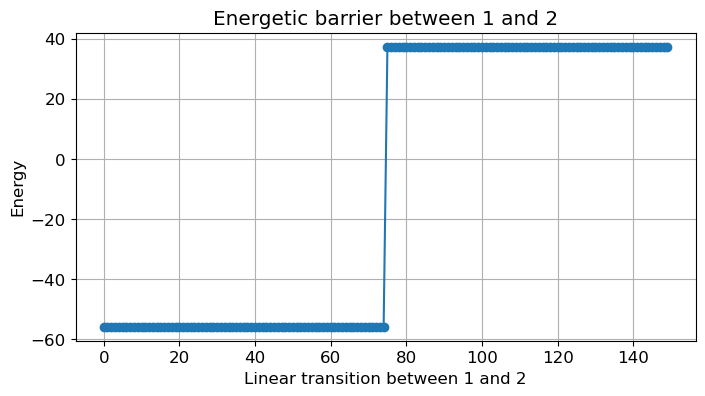

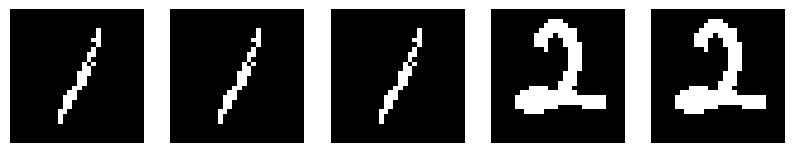

In [261]:
aE = np.load('TestTrain/a_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
bE = np.load('TestTrain/b_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')
wE = np.load('TestTrain/w_RBM_3_3_2_RMSprop_0.05-0.05_Ep150_Mini20_reg0.001__0__0316_1817.npy')

EnergyBarrier(aE, bE, wE, ShowBarrier=True)

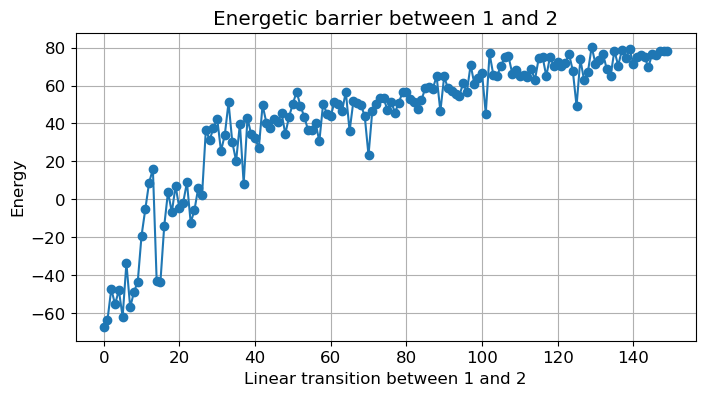

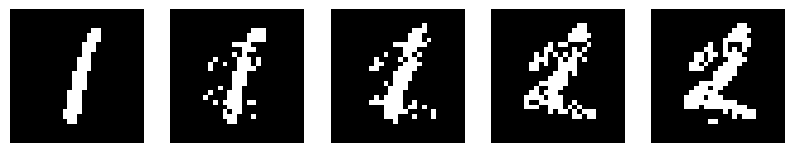

In [263]:
EnergyBarrier(aE, bE, wE, ShowBarrier=False)